# Introduction
<hr style="border:2px solid black"> </hr>


**What?** ADAM optmiser



# Adam and the others
<hr style="border:2px solid black"> </hr>


- **Classic** gradient descent methods use a single step size (read it learning rate) for all input variables. 
- **AdaGrad** and **RMSProp** update the algorithm to use a separate step size for each input variable but may result in a step size that rapidly decreases to very small values.

- **Adam** stands for Adaptive Movement Estimation algorithm. It is characterised by:
    - Like AdaGrad and RMSProp automatically use a different lr for each variables
    - Additionally adapts the learning rate for each input variable.

- These changes result in:
    - Acceleration to convergence (decrese of function evaluations)
    - Find better optima



# Import modules
<hr style="border:2px solid black"> </hr>

In [221]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from math import sqrt
from numpy import asarray, arange, meshgrid
from numpy.random import rand, seed
import warnings
warnings.filterwarnings("ignore")

# Test function
<hr style="border:2px solid black"> </hr>


- Test function `z = x^2+y^2`: convex function with a single minimum located at `[0.0,0.0]`.
- Both variable range btw `[-1.0,1.0]`
- The partial derivatives are: `dz/dx = 2*y` and `dz/dy = 2*x`. If we combine them into a vector we get the Jacobian, which nothing more than a matrix (here a vector though) of all the partial derivatives.



In [4]:
def objective(x, y):
    return x**2.0 + y**2.0

def derivative(x, y):
    return asarray([x * 2.0, y * 2.0])

In [19]:
# Compute the function domain

# define range for input
r_min, r_max = -1.0, 1.0
# sample input range uniformly at 0.1 increments
xaxis = arange(r_min, r_max, 0.1)
yaxis = arange(r_min, r_max, 0.1)
# create a mesh from the axis
x, y = meshgrid(xaxis, yaxis)

# Compute function points
z = objective(x, y)

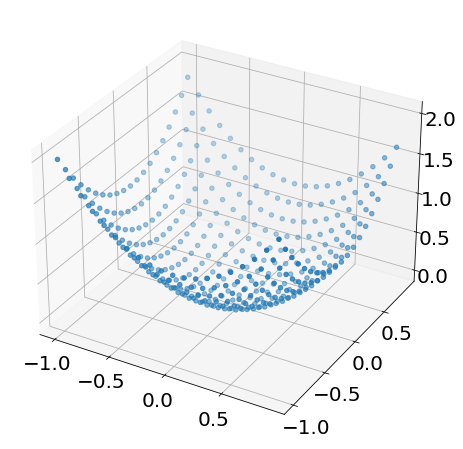

In [21]:
rcParams['figure.figsize'] = 17, 8
rcParams['font.size'] = 20
         
fig = plt.figure()
ax = plt.gca(projection='3d')
ax.scatter(x, y, z)
plt.show()

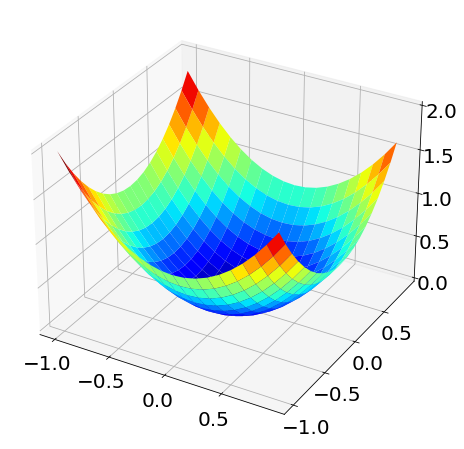

In [36]:
# 3D plotting

rcParams['figure.figsize'] = 17, 8
rcParams['font.size'] = 20

fig = plt.figure()
ax = plt.gca(projection='3d')
ax.plot_surface(x, y, z, cmap='jet')
plt.show()

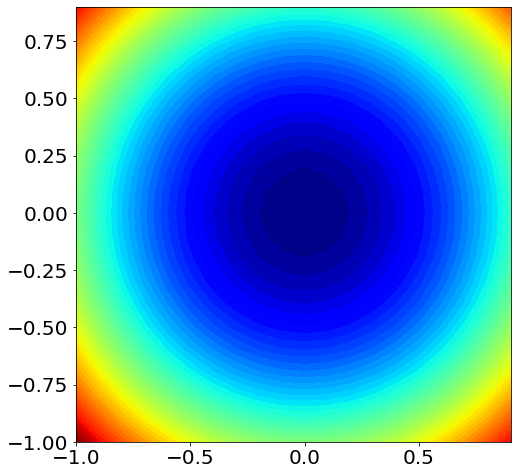

In [38]:
# 2D project visaulisation

fig = plt.figure()
ax = fig.add_subplot(111) 

# create a filled contour plot with 
#50 levels and jet color scheme

ax.contourf(x, y, z, levels=50, cmap='jet')
ax.set_aspect('equal')
plt.show()

# Adam implementation
<hr style="border:2px solid black"> </hr>


- **Step #0** - Randomly initialise variables.

- **Step #1** - Initialise to zero the first and second moments. We have two variables so we get

- **Step #2** - Get the objective function derivative. In this case it can be computed analytically. If this not available you then use finite difference. A cool alternative could be to implement the complex step instead so you get rid of the cancellation error which FDs suffer from.

- **Step #3** - Get the first and second moments (`beta1` and `beta2` are two hyperparameters)
    - `m(t) = beta1 * m(t-1) + (1 - beta1) * g(t)`
    - `v(t) = beta2 * v(t-1) + (1 - beta2) * g(t)^2`

- **Step #4** - Get the bias correction for both first and second moments. This is done because they are initialized as (vectors of) 0’s, leading to moment estimates that are biased towards zero, especially during the initial timesteps, and especially when the decay rates are small (i.e. the betas are close to 1). The good news is that this initialization bias can be easily counteracted, resulting in bias-corrected estimates. Please note how betas are decayed,
    - `mhat(t) = m(t) / (1 - beta1(t))`
    - `vhat(t) = v(t) / (1 - beta2(t))`

- **Step #5** - Get the final update. This is in the form (high level gradient descent algortithm): `new = old - alpha*gradient`
    - `x(t) = x(t-1) - alpha * mhat(t) / (sqrt(vhat(t)) + eps)`

- Recall that **Steps #3,4 and 5** are done inside another loop as the Adam optimier build a specific solution for each DV.



In [202]:
def adam(obective, derivative, bounds, n_iter, alpha, beta1, beta2, tol=1.e-6):
    """Adam optimiser

    Parameters
    ----------
    obective

    derivative

    bounds

    n_iter

    alpha

    beta1

    beta2    

    tol : float defail = 1.e-6
        tolerance on the objective function. If the value of the 
        objective function falls below this tollerance, the iteration 
        is stopped.

    Returns
    -------
    x : np.array()

    score : float
        The value of the objective function

    solutions
    """

    print("")
    for k, value in enumerate(bounds):
        print("Bounds for variable No:", k, " are", value)
    print("No of iteration: ", n_iter)
    print("Alpha", alpha)
    print("Beta1", beta1)
    print("Beta2", beta2)
    print("Eps", eps)
    print("Tol", tol)

    # Keep track of the iteration solutions
    history_DVs = []
    history_I = []

    # Generate an initial point
    x = bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
    score = objective(x[0], x[1])
    print("Inital values", x, " and initial function value", score)
    print("x shape:", x.shape)
    print("")

    # Initialize first and second moments to zero
    m = [0.0 for _ in range(bounds.shape[0])]
    v = [0.0 for _ in range(bounds.shape[0])]
    print("m shape:", len(m))
    print("v shape:", len(v))
    print("")

    print("Start gradient descent with Adam")

    # Start gradient descent update
    for t in range(n_iter):

        # Get gradient of the objective function at the current DV values
        g = derivative(x[0], x[1])

        # Build a solution one variable at a time
        for i in range(x.shape[0]):

            # Get the fist and second moments
            m[i] = beta1 * m[i] + (1.0 - beta1) * g[i]
            v[i] = beta2 * v[i] + (1.0 - beta2) * g[i]**2

            # Add the baias - please note how betas are decayed
            mhat = m[i] / (1.0 - beta1**(t+1))
            vhat = v[i] / (1.0 - beta2**(t+1))

            # Get the final update (eps is there to avoid division by zero)
            eps = 1e-8
            x[i] = x[i] - alpha * mhat / (sqrt(vhat) + eps)

        # Evaluate objectuve function given the candidate point
        score = objective(x[0], x[1])

        # Report progress on console
        print('|- Iter No=%d | current DVs=%s | Obj function=%.8f' %
              (t, x, score))

        # Keep track of the history for both DVs and objective function
        history_DVs.append(x.copy())
        history_I.append(score)

        if score <= tol:
            print("Value below tollerance! Stop and exit!")
            break

    print("")
    print('|- Iter No=%d | best DVs=%s | Obj function=%.8f' % (t, x, score))
    print("End gradient descent with Adam")

    return x, score, history_DVs, history_I

In [203]:
# seed the pseudo random number generator
seed(1)
# define range for input
bounds = asarray([[-1.0, 1.0], [-1.0, 1.0]])
# define the total iterations
n_iter = 150
# steps size
alpha = 0.02
# factor for average gradient
beta1 = 0.8
# factor for average squared gradient
beta2 = 0.999
# ?? see artivle, I forgot!
eps = 1e-8
# tolernace on the objective function
tol = 1e-3

In [204]:
# perform the gradient descent search with adam
best, score, history_DVs, history_I = adam(objective, derivative, bounds, n_iter, alpha, beta1, beta2, tol)


Bounds for variable No: 0  are [-1.  1.]
Bounds for variable No: 1  are [-1.  1.]
No of iteration:  150
Alpha 0.02
Beta1 0.8
Beta2 0.999
Eps 0.001
Tol 1e-06
Inital values [-0.16595599  0.44064899]  and initial function value 0.22171292045649288
x shape: (2,)

m shape: 2
v shape: 2

Start gradient descent with Adam
|- Iter No=0 | current DVs=[-0.14601607  0.42067165] | Obj function=0.19828533
|- Iter No=1 | current DVs=[-0.1262611   0.40075145] | Obj function=0.17654359
|- Iter No=2 | current DVs=[-0.10684577  0.38092915] | Obj function=0.15652304
|- Iter No=3 | current DVs=[-0.08795232  0.36124738] | Obj function=0.13823528
|- Iter No=4 | current DVs=[-0.06979052  0.34175022] | Obj function=0.12166393
|- Iter No=5 | current DVs=[-0.05259445  0.32248277] | Obj function=0.10676131
|- Iter No=6 | current DVs=[-0.03661474  0.30349069] | Obj function=0.09344724
|- Iter No=7 | current DVs=[-0.02210513  0.28481977] | Obj function=0.08161094
|- Iter No=8 | current DVs=[-0.00930329  0.2665154 

In [205]:
# double checking
print(best)
objective(best[0],best[1])

[ 8.72311002e-04 -7.20515372e-06]


7.609783986695471e-07

Text(0, 0.5, 'Y-label')

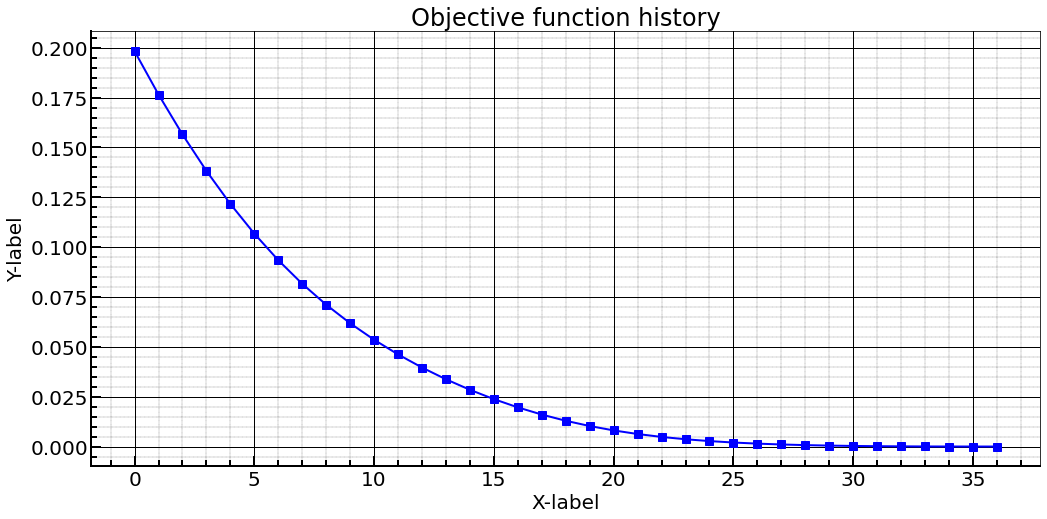

In [222]:
fig = plt.figure() 
plt.title("Objective function history")
ax = fig.add_subplot(111) 

plt.plot(range(len(history_I)), history_I, "-bs", lw = 2, ms = 8)

ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which = 'major', direction='in', length=10, width=2)
ax.tick_params(which = 'minor', direction='in', length=6, width=2)

ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.minorticks_on()

ax.set_xlabel("X-label")
ax.set_ylabel("Y-label")

#plt.legend(loc = 'upper left', ncol = 4, fontsize = 25)

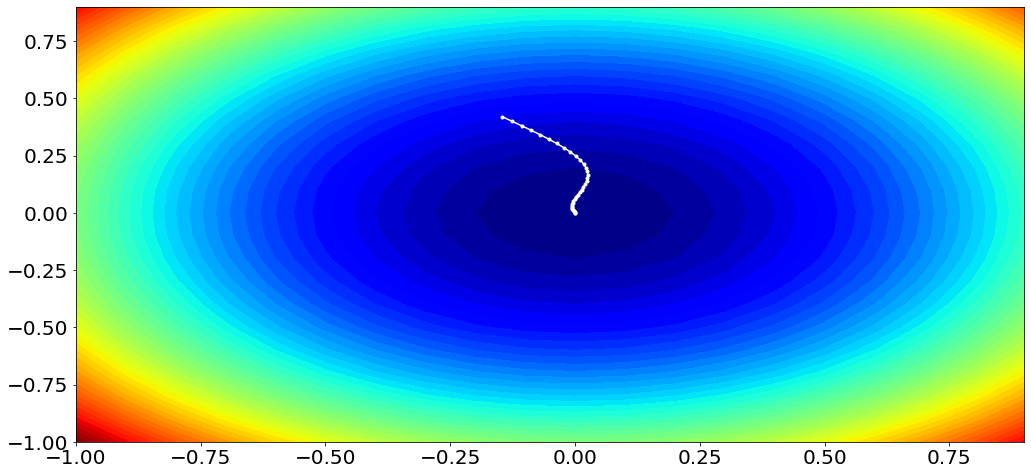

In [223]:
# sample input range uniformly at 0.1 increments
xaxis = arange(bounds[0,0], bounds[0,1], 0.1)
yaxis = arange(bounds[1,0], bounds[1,1], 0.1)
# create a mesh from the axis
x, y = meshgrid(xaxis, yaxis)
# compute targets
results = objective(x, y)
# create a filled contour plot with 50 levels and jet color scheme
plt.contourf(x, y, results, levels=50, cmap='jet')

# plot the sample as black circles
history_DVs = asarray(history_DVs)

plt.plot(history_DVs[:, 0], history_DVs[:, 1], '.-', color='w')
# show the plot
plt.show()

# Comparison Adam vs. Simple Gradient Descent
<hr style="border:2px solid black"> </hr>

In [229]:
def simple_gradient_descent(obective, derivative, bounds, n_iter, alpha, tol=1.e-6):
    """Adam optimiser

    Parameters
    ----------
    obective

    derivative

    bounds

    n_iter

    eps : floar default = 1e-8

    tol : float defail = 1.e-6
        tolerance on the objective function. If the value of the 
        objective function falls below this tollerance, the iteration 
        is stopped.

    Returns
    -------
    x : np.array()

    score : float
        The value of the objective function

    solutions
    """

    print("")
    for k, value in enumerate(bounds):
        print("Bounds for variable No:", k, " are", value)
    print("No of iteration: ", n_iter)
    print("Alpha", alpha)
    print("Tol", tol)

    # Keep track of the iteration solutions
    history_DVs = []
    history_I = []

    # Generate an initial point
    x = bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
    score = objective(x[0], x[1])
    print("Inital values", x, " and initial function value", score)
    print("x shape:", x.shape)
    print("")

    print("Start gradient descent with Adam")

    # Start gradient descent update
    for t in range(n_iter):

        # Get gradient of the objective function at the current DV values
        g = derivative(x[0], x[1])

        # Build a solution one variable at a time
        for i in range(x.shape[0]):

            # Get the final update
            # x(t) = x(t-1) - alpha * mhat(t) / (sqrt(vhat(t)) + eps)
            x[i] = x[i] - alpha*g[i]

        # Evaluate objectuve function given the candidate point
        score = objective(x[0], x[1])

        # Report progress on console
        print('|- Iter No=%d | current DVs=%s | Obj function=%.8f' %
              (t, x, score))

        # Keep track of the history for both DVs and objective function
        history_DVs.append(x.copy())
        history_I.append(score)

        if score <= tol:
            print("Value below tollerance! Stop and exit!")
            break

    print("")
    print('|- Iter No=%d | best DVs=%s | Obj function=%.8f' % (t, x, score))
    print("End gradient descent with Adam")

    return x, score, history_DVs, history_I

In [230]:
# perform the gradient descent search with adam
best, score, history_DVs, history_I = simple_gradient_descent(objective, derivative, bounds, n_iter, alpha, tol)


Bounds for variable No: 0  are [-1.  1.]
Bounds for variable No: 1  are [-1.  1.]
No of iteration:  150
Alpha 0.02
Tol 0.001
Inital values [-0.62747958 -0.30887855]  and initial function value 0.489136575985023
x shape: (2,)

Start gradient descent with Adam
|- Iter No=0 | current DVs=[-0.60238039 -0.2965234 ] | Obj function=0.45078827
|- Iter No=1 | current DVs=[-0.57828518 -0.28466247] | Obj function=0.41544647
|- Iter No=2 | current DVs=[-0.55515377 -0.27327597] | Obj function=0.38287547
|- Iter No=3 | current DVs=[-0.53294762 -0.26234493] | Obj function=0.35285803
|- Iter No=4 | current DVs=[-0.51162972 -0.25185113] | Obj function=0.32519396
|- Iter No=5 | current DVs=[-0.49116453 -0.24177709] | Obj function=0.29969875
|- Iter No=6 | current DVs=[-0.47151795 -0.232106  ] | Obj function=0.27620237
|- Iter No=7 | current DVs=[-0.45265723 -0.22282176] | Obj function=0.25454810
|- Iter No=8 | current DVs=[-0.43455094 -0.21390889] | Obj function=0.23459153
|- Iter No=9 | current DVs=[-

# References
<hr style="border:2px solid black"> </hr>


- https://machinelearningmastery.com/adam-optimization-from-scratch/
- [Paper: Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980)
- [Gradient descent, Wikipefia](https://en.wikipedia.org/wiki/Gradient_descent)
- https://towardsdatascience.com/how-to-implement-an-adam-optimizer-from-scratch-76e7b217f1cc

